In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DS301\ Project

Mounted at /content/drive
/content/drive/MyDrive/DS301 Project


In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
file_path = 'goldprice2001.2.1--2024.1.1.xlsx'
df = pd.read_excel(file_path)
features = ['Gold Price', 'USD Index', 'CPI', 'Fed Rate', 'sp500']
target = 'Gold Price'
window_size = 10
# Do not scale features
X, y = [], []
data = df[features].values
target_data = df[target].values

for i in range(window_size, len(data)):
    X.append(data[i - window_size:i])  # (10, 5)
    y.append(target_data[i])           # unscaled target

X = np.array(X)  # (N, 10, 5)
y = np.array(y).reshape(-1, 1)

n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=64)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x):
        out = self.net(x)
        return out


class ODEBlock(nn.Module):
    def __init__(self, odefunc, time_tensor):
        super().__init__()
        self.odefunc = odefunc
        self.integration_time = time_tensor

    def forward(self, x):
        # x: (T, B, F)
        T, B, F = x.shape
        x0 = x[0]  # Initial state: shape (B, F)

        out = odeint(self.odefunc, x0, self.integration_time, method='rk4')  # out: (T, B, F)
        return out[-1]  # Final state at last time step: (B, F)


class NeuralODEModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.time_tensor = torch.linspace(0, 1, steps=10).to(device)
        self.odefunc = ODEFunc(input_dim).to(device)
        self.odeblock = ODEBlock(self.odefunc, self.time_tensor)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.transpose(0, 1)                     # (T, B, F)
        print("ODE input shape:", x.shape)        # ← Debug 1

        out = self.odeblock(x)                    # (B, F)
        print("ODE output shape:", out.shape)     # ← Debug 2

        output = self.fc(out)                     # (B, 1)
        print("Final output shape:", output.shape) # ← Debug 3

        return output

In [ ]:
input_dim = X_train.shape[2]
model = NeuralODEModel(input_dim=input_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
current_lr = 0.01
switched = False

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * xb.size(0)  # accumulate loss

    avg_train_loss = total_train_loss / len(train_dl.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor.to(device))
        val_loss = loss_fn(val_pred, y_val_tensor.to(device)).item()

    # LR switch
    if not switched and val_loss < 30000:
        print(f"\n📉 Switching learning rate from 0.01 → 0.001 at epoch {epoch}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
        current_lr = 0.001
        switched = True

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: LR = {current_lr:.5f}, Train Loss = {avg_train_loss:.4f}, Validation Loss = {val_loss:.4f}")


ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE output shape: torch.Size([64, 5])
Final output shape: torch.Size([64, 1])
ODE input shape: torch.Size([10, 64, 5])
ODE out

KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_test_np, test_pred))
mae = mean_absolute_error(y_test_np, test_pred)
r2 = r2_score(y_test_np, test_pred)

print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")



Test RMSE: 62.5345
Test MAE:  50.0332
Test R²:   0.5628


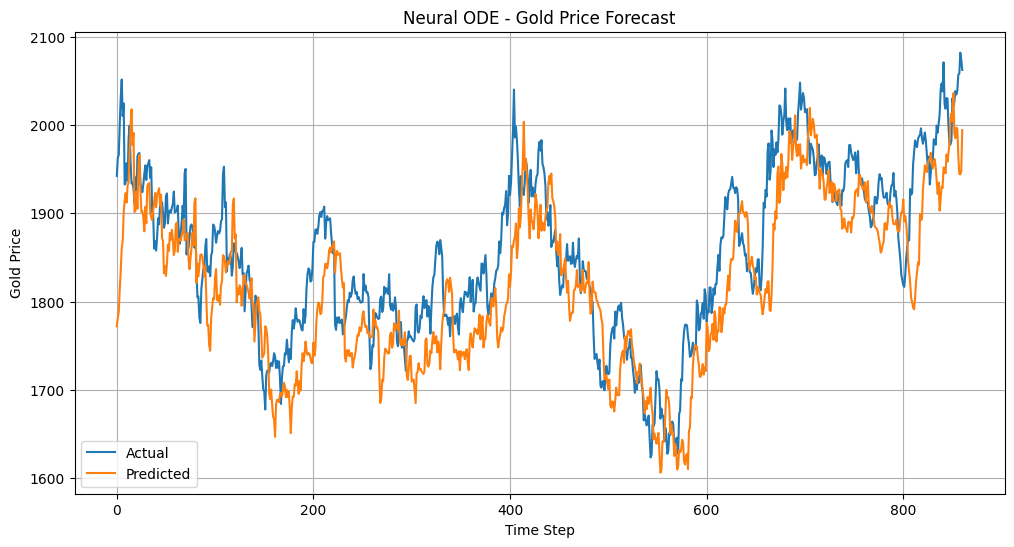

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.title('Neural ODE - Gold Price Forecast')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()